# Description

This notebook provides the training of different model architectures **after** electrode selection.

## setting up the environment

In [ ]:
RELATIVE_PATH = '../../data/'
FILE_PARAM = 'Subject_1.mat'

In [2]:
import sys
sys.path.append('../src')  
from data_loading import load_and_combine_mat_data
from preprocessing import preprocess_data
from evaluation import evaluate_model
from feature_selection import get_subject_indices
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.ndimage import median_filter
from sklearn.preprocessing import RobustScaler

from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

from scipy.signal import butter, filtfilt
from scipy.ndimage import median_filter
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## data loading

In [ ]:
mat_file_paths = [RELATIVE_PATH + FILE_PARAM]
X, y, Channels = load_and_combine_mat_data(mat_file_paths)

Combined EEG Data Shape (Samples, Channels, Trials): (512, 128, 200)
Combined Labels Shape: (200,)
Channels: ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D19', 'D20', 'D21', 'D22', 'D23', 'D24', 'D25', 'D26', 'D27', 'D28', 'D29', 'D30', 'D31', 'D32']


In [4]:
indices = get_subject_indices(FILE_PARAM)

In [5]:
X = X[:,indices,:]

## data preprocessing

In [6]:
X_preprocessed =  preprocess_data(X)
print(X_preprocessed.shape)

(512, 8, 200)


# Modeling

## MLP

In [7]:
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),       # Fewer neurons and layers
    activation='relu',                  # ReLU activation function
    solver='adam',                      # Adam optimizer
    alpha=0.01,                         # Increased L2 regularization (weight decay)
    learning_rate_init=0.001,           # Learning rate
    max_iter=300,                       # Set maximum iterations
    random_state=42,
    early_stopping=True,                # Early stopping to prevent overfitting
    validation_fraction=0.2,            # Use 20% of the training data for validation
    n_iter_no_change=10                 # Stop if no improvement for 10 iterations
)

In [8]:
X = np.transpose(X_preprocessed, (2, 0, 1))  
X = X.reshape(200, -1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Initialize the RobustScaler
scaler = RobustScaler()
# Fit Data of trainset and transform testset
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  

In [10]:
print("X_train_scaled shape:", X_train_scaled.shape)  
print("X_test_scaled shape:", X_test_scaled.shape) 

X_train_scaled shape: (160, 4096)
X_test_scaled shape: (40, 4096)


In [11]:
mlp.fit(X_train_scaled, y_train)

MLPClassifier(alpha=0.01, early_stopping=True, hidden_layer_sizes=(128, 64),
              max_iter=300, random_state=42, validation_fraction=0.2)

In [12]:
evaluate_model(mlp, X_test_scaled, y_test, X_train_scaled, y_train)

Test Accuracy: 0.925
Classification Report Test:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.0       1.00      0.87      0.93        15
         2.0       0.89      0.89      0.89         9
         3.0       0.83      1.00      0.91        10

    accuracy                           0.93        40
   macro avg       0.93      0.94      0.93        40
weighted avg       0.93      0.93      0.93        40

Train Accuracy: 0.96875
Classification Report Train:
               precision    recall  f1-score   support

         0.0       0.98      0.95      0.97        44
         1.0       0.95      1.00      0.97        35
         2.0       0.97      0.93      0.95        41
         3.0       0.98      1.00      0.99        40

    accuracy                           0.97       160
   macro avg       0.97      0.97      0.97       160
weighted avg       0.97      0.97      0.97       160



{'test_accuracy': 0.925,
 'test_report': '              precision    recall  f1-score   support\n\n         0.0       1.00      1.00      1.00         6\n         1.0       1.00      0.87      0.93        15\n         2.0       0.89      0.89      0.89         9\n         3.0       0.83      1.00      0.91        10\n\n    accuracy                           0.93        40\n   macro avg       0.93      0.94      0.93        40\nweighted avg       0.93      0.93      0.93        40\n',
 'train_accuracy': 0.96875,
 'train_report': '              precision    recall  f1-score   support\n\n         0.0       0.98      0.95      0.97        44\n         1.0       0.95      1.00      0.97        35\n         2.0       0.97      0.93      0.95        41\n         3.0       0.98      1.00      0.99        40\n\n    accuracy                           0.97       160\n   macro avg       0.97      0.97      0.97       160\nweighted avg       0.97      0.97      0.97       160\n'}

## BiLSTM

In [13]:
X = np.transpose(X_preprocessed, (0, 1, 2))  
print(X.shape)
X = np.transpose(X, (2, 0, 1))  
print(X.shape)
# Ensure y is defined correctly
y = np.array(y)  # Ensure y is a numpy array if it isn't already

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

(512, 8, 200)
(200, 512, 8)


In [14]:
# Print the shapes to confirm
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_test.shape)

X_train shape: (160, 512, 8)
X_val shape: (40, 512, 8)
y_train shape: (160,)
y_val shape: (40,)


In [15]:
# Initialize RobustScaler
scaler = RobustScaler()

# Reshape each to 2D, apply scaling, then reshape back to original shape
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])  
X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])        

# Scale the reshaped data
X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val_reshaped).reshape(X_val.shape)

In [16]:
# Print shapes after scaling
print("X_train shape after scaling:", X_train_scaled.shape)  
print("X_val shape after scaling:", X_val_scaled.shape)  
print("y_train shape:", y_train.shape)                       
print("y_val shape:", y_val.shape) 

X_train shape after scaling: (160, 512, 8)
X_val shape after scaling: (40, 512, 8)
y_train shape: (160,)
y_val shape: (40,)


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
import tensorflow as tf


def create_bilstm_model(input_shape=(512, 128), num_classes=4):
    model = Sequential()

    # First Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(256, return_sequences=True), input_shape=input_shape))
    model.add(BatchNormalization())

    # Second Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(128)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))  # Adjust dropout rate as needed

    # Fully connected layer for classification
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))  # Adjust dropout rate as needed

    # Output layer for classification
    model.add(Dense(num_classes, activation='softmax'))

    return model

2024-11-10 14:09:09.383200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-10 14:09:09.398187: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-10 14:09:09.402696: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 14:09:09.414499: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-10 14:09:10.234482: W tensorflow/compiler/tf2

In [18]:
# Build and compile the model
input_shape = (512, 8)  # (Time steps, Channels) for each sample
model = create_bilstm_model(input_shape=input_shape)

# Define Nadam optimizer
optimizer = Nadam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

2024-11-10 14:09:17.395502: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13294 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:e7:00.0, compute capability: 8.6
2024-11-10 14:09:17.397941: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13294 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:e8:00.0, compute capability: 8.6
/home/jovyan/myenv/lib/python3.9/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 512, 512)       │       542,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,219,140 (4.65 MB)

 Trainable params: 1,217,476 (4.64 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [19]:
def cyclical_lr(step_size, min_lr=1e-5, max_lr=5e-3):
    def clr(epoch):
        cycle = np.floor(1 + epoch / (2 * step_size))
        x = np.abs(epoch / step_size - 2 * cycle + 1)
        lr = min_lr + (max_lr - min_lr) * np.maximum(0, (1 - x))
        return lr
    return clr

# Set cyclical learning rate scheduler
clr_callback = LearningRateScheduler(cyclical_lr(step_size=200))

# Train the model
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_val_scaled, y_val),
                    epochs=50,
                    batch_size=64,
                    callbacks=[clr_callback])

Epoch 1/50


2024-11-10 14:09:25.041411: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 405ms/step - accuracy: 0.2414 - loss: 2.1346 - val_accuracy: 0.1250 - val_loss: 1.3971 - learning_rate: 1.0000e-05
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.2863 - loss: 2.0906 - val_accuracy: 0.2000 - val_loss: 1.3925 - learning_rate: 3.4950e-05
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.2977 - loss: 1.9686 - val_accuracy: 0.2250 - val_loss: 1.3871 - learning_rate: 5.9900e-05
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 0.2801 - loss: 1.7581 - val_accuracy: 0.3500 - val_loss: 1.3791 - learning_rate: 8.4850e-05
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - accuracy: 0.4004 - loss: 1.4030 - val_accuracy: 0.4500 - val_loss: 1.3709 - learning_rate: 1.0980e-04
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.5387 - loss: 1.0587 - val_accuracy: 0.4500 - val_loss: 1.3641 - learning_rate: 1.3475e-04
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.5480 - loss: 1.0527 - v

## CNN

In [20]:
X_cnn = X_preprocessed.transpose(2, 0, 1).reshape(200, 512, 8, 1)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, random_state=42)

In [22]:
# Reshape X_train and X_test to 2D for scaling
X_train_reshaped = X_train.reshape(-1, X_train.shape[2])
X_test_reshaped = X_test.reshape(-1, X_test.shape[2])

# Initialize and fit RobustScaler on X_train
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape back to the original shape
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

In [23]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

X_train_scaled shape: (160, 512, 8, 1)
X_test_scaled shape: (40, 512, 8, 1)


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, SeparableConv2D, AveragePooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import Nadam

# Define the EEGNet model
def create_eegnet_model(input_shape=(512, 8, 1), num_classes=4):
    model = Sequential()

    # First Conv2D block
    model.add(Conv2D(4, (64, 1), padding='same', input_shape=input_shape, use_bias=False))  # Reduced filters
    model.add(BatchNormalization())

    # Depthwise Conv2D block
    model.add(DepthwiseConv2D((1, 1), use_bias=False, depth_multiplier=2, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(AveragePooling2D((1, 4)))  # Pooling along the width
    model.add(Dropout(0.2))

    # Separable Conv2D block
    model.add(SeparableConv2D(8, (1, 16), use_bias=False, padding='same'))  # Reduced filters
    model.add(BatchNormalization())
    model.add(Activation('elu'))

    # Adjust the pooling size here to avoid negative dimensions
    model.add(AveragePooling2D((1, 2)))  # Reduced from (1, 4) to (1, 2)
    model.add(Dropout(0.2))

    # Flatten and classification
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Build and compile the model
model = create_eegnet_model()

# Define Nadam optimizer
optimizer = Nadam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


/home/jovyan/myenv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 512, 8, 4)      │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512, 8, 4)      │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 512, 8, 8)      │             8 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512, 8, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512, 8, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 512, 2, 8)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512, 2, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 512, 2, 8)      │           192 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512, 2, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 512, 2, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 512, 1, 8)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512, 1, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │        16,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,924 (66.11 KB)

 Trainable params: 16,884 (65.95 KB)

 Non-trainable params: 40 (160.00 B)

In [25]:
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np

# Cyclical learning rate function
def cyclical_lr(step_size, min_lr=1e-5, max_lr=5e-3):
    def clr(epoch):
        cycle = np.floor(1 + epoch / (2 * step_size))
        x = np.abs(epoch / step_size - 2 * cycle + 1)
        lr = min_lr + (max_lr - min_lr) * np.maximum(0, (1 - x))
        return lr
    return clr

# Set cyclical learning rate scheduler
clr_callback = LearningRateScheduler(cyclical_lr(step_size=200))

# Train the model
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_test_scaled, y_test),
                    epochs=50,  # Reduced epochs
                    batch_size=64,  # Reduced batch size
                    callbacks=[clr_callback])

Epoch 1/50


I0000 00:00:1731247824.189782   61281 service.cc:146] XLA service 0x7c6250001700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731247824.189842   61281 service.cc:154]   StreamExecutor device (0): NVIDIA A16, Compute Capability 8.6
I0000 00:00:1731247824.189850   61281 service.cc:154]   StreamExecutor device (1): NVIDIA A16, Compute Capability 8.6
2024-11-10 14:10:24.331525: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2227 - loss: 1.6566

I0000 00:00:1731247830.498315   61281 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.2332 - loss: 1.6559 - val_accuracy: 0.1750 - val_loss: 1.3870 - learning_rate: 1.0000e-05
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2133 - loss: 1.5930 - val_accuracy: 0.2250 - val_loss: 1.3866 - learning_rate: 3.4950e-05
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2121 - loss: 1.6594 - val_accuracy: 0.2250 - val_loss: 1.3858 - learning_rate: 5.9900e-05
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2734 - loss: 1.5737 - val_accuracy: 0.2250 - val_loss: 1.3846 - learning_rate: 8.4850e-05
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3195 - loss: 1.5349 - val_accuracy: 0.2500 - val_loss: 1.3828 - learning_rate: 1.0980e-04
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.2898 - loss: 1.4914 - val_accuracy: 0.3000 - val_loss: 1.3803 - learning_rate: 1.3475e-04
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3168 - loss: 1.4346 - val_accur

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step
Confusion Matrix:
 [[ 0  0  6  0]
 [ 0  0 15  0]
 [ 0  0  9  0]
 [ 0  0 10  0]]


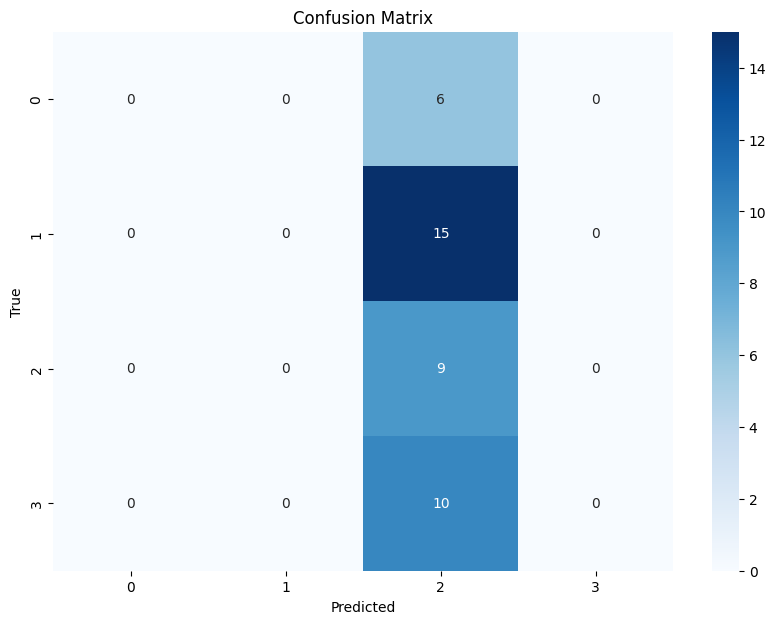

Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.00      0.00      0.00        15
         2.0       0.23      1.00      0.37         9
         3.0       0.00      0.00      0.00        10

    accuracy                           0.23        40
   macro avg       0.06      0.25      0.09        40
weighted avg       0.05      0.23      0.08        40



/home/jovyan/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jovyan/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jovyan/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


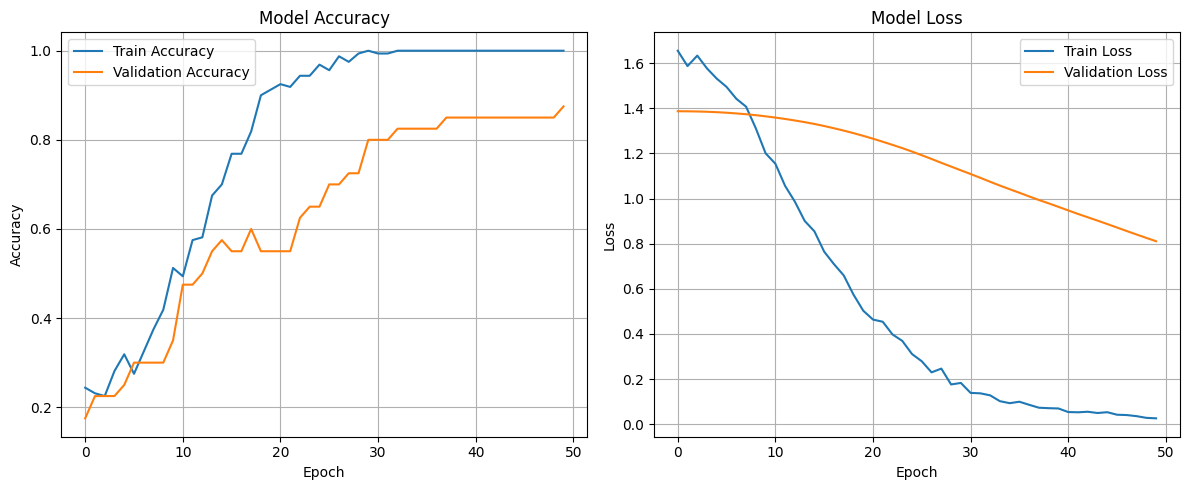

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the validation set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_classes))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
